## NCrystal materials in McStas

In this example we install McStas and Ncrystal using conda / mamba, and create a instrument simulation for a simple transmission beamline with a NCrystal sample.

## Preamble
Install dependencies and prepare plots. This installation is done with mamba to include both NCrystal and McStas. Feel free to edit as you wish:

In [1]:
try:
    import google.colab as google_colab
except ModuleNotFoundError:
    google_colab=None#not on google colab
if google_colab:
    print("WARNING: Installing mambaforge. This will cause your notebook "
          "to say it crashed and restart itself. This is expected behaviour!!")
    %pip -q install condacolab
    import condacolab
    condacolab.install_mambaforge()
try:
    import google.colab as google_colab
except ModuleNotFoundError:
    google_colab=None#not on google colab
import pathlib
import os
import shutil
import subprocess
if not shutil.which('mcrun') or not shutil.which('nctool'):
    if not google_colab:
        raise RuntimeError('required dependencies not installed!')
    else:
      !mamba install mcstas-core ncrystal ipympl >/dev/null && echo installed mcstas-core and ncrystal
if not 'MCSTAS' in os.environ:
    _mcstasrd=subprocess.run(['mcrun','--showcfg=resourcedir'],
                              capture_output=True,check=True).stdout.decode().strip()
    os.environ['MCSTAS']=_mcstasrd
if google_colab:
    os.environ['CONDA_PREFIX']=str(pathlib.Path(shutil.which('nctool')).parent.parent)
mcstasdir=pathlib.Path(os.environ['MCSTAS'])
assert mcstasdir.is_dir(), "MCSTAS resource dir missing"
#enable inline and interactive matplotlib plots and import NCrystal:
if google_colab:
    google_colab.output.enable_custom_widget_manager()
%matplotlib ipympl
import matplotlib
matplotlib.rcParams.update({"figure.autolayout": True})
#always import NCrystal:
import NCrystal as NC
assert NC.version_num >=  3009007, "too old NCrystal found"
NC.test() #< quick unit test that installation works

✨🍰✨ Everything looks OK!
Tests completed succesfully


### Additional modules:

In [2]:
import os
import pathlib
import numpy as np
import matplotlib.pyplot as plt

## Example

This cell writes the McStas instrument file. We write it this way because in Google Colab files are deleted when the runtime is regenerated.

We also define a few variables that will be used in the simulation.

In [3]:
beam_width = 0.01 # m
beam_height = 0.01 # m
sample_thickness = 0.01 # m
nbins = 700
cfg = 'C_sg194_pyrolytic_graphite.ncmat'
source_mon1_distance = 0.5 # m
mon1_sample_distance = 0.5 # m
sample_mon2_distance = 0.5 # m
NParticles = 5000000
min_lambda = 1.0
max_lambda = 8.0

txt = f'''/*******************************************************************************
*         McStas instrument definition URL=http://www.mcstas.org
*
* Instrument: NCrystal_example
*
* %Identification
* Written by: NCrystal developers
* Date: 2015
* Origin: ESS
* %INSTRUMENT_SITE: NCrystal
*
* Example instrument for NCrystal_sample use
*
* %Description
* Steady-state source diffractometer with (Ge-511) monochromator and powder-sample via NCrystal
*
*
*  This file is originally part of NCrystal (see https://mctools.github.io/ncrystal/)
*
*  Copyright 2015-2022 NCrystal developers
*
*  Licensed under the Apache License, Version 2.0 (the "License");
*  you may not use this file except in compliance with the License.
*  You may obtain a copy of the License at
*
*      http://www.apache.org/licenses/LICENSE-2.0
*
*  Unless required by applicable law or agreed to in writing, software
*  distributed under the License is distributed on an "AS IS" BASIS,
*  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
*  See the License for the specific language governing permissions and
*  limitations under the License.
*
*
* %Example: sample_cfg="Y2O3_sg206_Yttrium_Oxide.ncmat;density=0.6x" Detector: powder_pattern_detc_I=6.3e-11
*
* %Parameters
* sample_cfg: [string] Material string for the
*
* %Link
* A reference/HTML link for more information
*
* %End
*******************************************************************************/
DEFINE INSTRUMENT NCrystal_example(string sample_cfg="Y2O3_sg206_Yttrium_Oxide.ncmat;density=0.6x")

DECLARE
%{{
%}}

INITIALIZE
%{{
%}}

TRACE

/* Example instrument in which two NCrystal_sample component instances are used
 to model respectively a Ge-511 monochromator and secondly an Yttrium-Oxide
 powder sample. Source and detectors are deliberately kept very simple.

 The orientation of the monochromator and the value of the central wavelength,
 lambda0, is set up in order for the neutrons at lambda0 to experience a 90 degree
 Bragg reflection (thetaBragg=45 degree) on the Ge511 plane, directing the reflected
 neutrons towards the sample (the d-spacing of Ge511 is 1.08876Aa):

           lambda = sin(45degree)*2*1.08876Aa = 1.539739Aa

 Note that the d-spacing, 1.08876Aa, of Ge511 can be found by the command:

    ncrystal_inspectfile --dump  "Ge_sg227.ncmat"

 Alternatively, it could have been extracted programatically here in the instrument file with:

  #include "NCrystal/ncrystal.h"
  ncrystal_info_t monochromator_info = ncrystal_create_info("Ge_sg227.ncmat");
  double dspacing_Ge511 = ncrystal_info_dspacing_from_hkl( monochromator_info, 5,1,1 );
  ncrystal_unref(&monochromator_info);

*/

COMPONENT origin = Progress_bar()
  AT (0, 0, 0) RELATIVE ABSOLUTE

 COMPONENT source =   Source_gen(Lmin={min_lambda}, Lmax={max_lambda}, xwidth={beam_width}, yheight={beam_height}, focus_xw={beam_width}, focus_yh={beam_height}, dist=100)
   AT (0, 0, 0) RELATIVE origin

COMPONENT monitor1 = L_monitor(xmin={-beam_width/2}, xmax={beam_width/2}, ymin={-beam_height/2}, ymax={beam_height/2}, nL={nbins}, filename="monitor1.dat", Lmin={min_lambda},
                     Lmax={max_lambda},restore_neutron=1)
  AT (0, 0, {source_mon1_distance}) RELATIVE source

SPLIT COMPONENT powder_sample = NCrystal_sample(xwidth=10.0, yheight=10.0,zdepth={sample_thickness},
                                          cfg=sample_cfg)
 AT (0, 0, {mon1_sample_distance}) RELATIVE monitor1

COMPONENT monitor2 = L_monitor(xmin={-beam_width/2}, xmax={beam_width/2}, ymin={-beam_height/2}, ymax={beam_height/2}, nL={nbins}, filename="monitor2.dat", Lmin={min_lambda},
                     Lmax={max_lambda},restore_neutron=1)
  AT (0, 0, {sample_mon2_distance}) RELATIVE powder_sample

END
'''

with open('transmission_example.instr','w') as f:
  f.write(txt)

Check the instrument file:

In [4]:
!cat transmission_example.instr

/*******************************************************************************
*         McStas instrument definition URL=http://www.mcstas.org
*
* Instrument: NCrystal_example
*
* %Identification
* Written by: NCrystal developers
* Date: 2015
* Origin: ESS
* %INSTRUMENT_SITE: NCrystal
*
* Example instrument for NCrystal_sample use
*
* %Description
* Steady-state source diffractometer with (Ge-511) monochromator and powder-sample via NCrystal
*
*
*  This file is originally part of NCrystal (see https://mctools.github.io/ncrystal/)
*
*  Copyright 2015-2022 NCrystal developers
*
*  Licensed under the Apache License, Version 2.0 (the "License");
*  you may not use this file except in compliance with the License.
*  You may obtain a copy of the License at
*
*      http://www.apache.org/licenses/LICENSE-2.0
*
*  Unless required by applicable law or agreed to in writing, software
*  distributed under the License is distributed on an "AS IS" BASIS,
*  WITHOUT WARRANTIES OR CONDITIONS OF ANY

Now we run McStas:

In [5]:
outdir = pathlib.Path('./NCrystal_example_output')
shutil.rmtree(outdir,ignore_errors=True)
!mcrun transmission_example.instr sample_cfg={cfg} -d {outdir} --ncount={NParticles}

INFO: Using directory: "NCrystal_example_output"
INFO: Regenerating c-file: transmission_example.c
Info:    'NCrystal_sample' is a contributed component.

-----------------------------------------------------------

Generating single GPU kernel or single CPU section layout: 
-> SPLIT N at component powder_sample

-----------------------------------------------------------

Generating GPU/CPU -DFUNNEL layout:
Component powder_sample is NOACC, CPUONLY=1
-> FUNNEL mode enabled, SPLIT within buffer.
-> SPLIT within buffer at component powder_sample
-> GPU kernel from component monitor2

-----------------------------------------------------------
CFLAGS= -Wl,-rpath,CMD(ncrystal-config --show libdir) -Wl,CMD(ncrystal-config --show libpath) -ICMD(ncrystal-config --show includedir) -DFUNNEL 
INFO: Recompiling: ./transmission_example.out
lto-wrapper: warning: using serial compilation of 2 LTRANS jobs
lto-wrapper: note: see the ]8;;https://gcc.gnu.org/onlinedocs/gcc/Optimize-Options.html#index-

Plot incident monitor

# Format: McCode with text headers
# URL: http://www.mccode.org
# Creator:  3.4.67, git
# Instrument: transmission_example.instr
# Ncount: 5000000
# Trace: no
# Gravitation: no
# Seed: 1725273393676762
# Directory: NCrystal_example_output
# Param: sample_cfg=C_sg194_pyrolytic_graphite.ncmat
# Date: Mon Sep  2 10:36:59 2024 (1725273419)
# type: array_1d(700)
# Source: NCrystal_example (transmission_example.instr)
# component: monitor1
# position: 0 0 0.5
# title: Wavelength monitor
# Ncount: 5000000
# filename: monitor1.dat
# statistics: X0=4.49846; dX=2.02052;
# signal: Min=9.653e-11; Max=1.03726e-10; Mean=1e-10;
# values: 7e-08 3.1305e-11 5e+06
# xvar: L
# yvar: (I,I_err)
# xlabel: Wavelength [AA]
# ylabel: Intensity
# xlimits: 1 8
# variables: L I I_err N
1.005 1.005479993e-10 1.186453531e-12 7182 
1.015 9.966599934e-11 1.181238325e-12 7119 
1.025 1.002959993e-10 1.184965814e-12 7164 


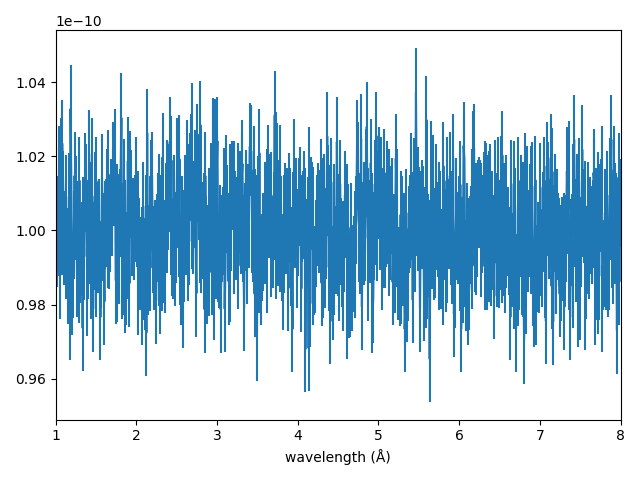

In [6]:
datafile = outdir / 'monitor1.dat'
assert datafile.exists(), "Monitor file not found"
!head -30 {datafile}

x=np.genfromtxt(datafile)
L, I, I_err, N = x.T

fig=plt.figure()
plt.errorbar(L,I,I_err)
plt.xlabel('wavelength (Å)')
plt.xlim(min_lambda, max_lambda)
plt.show()

Plot transmission monitor

# Format: McCode with text headers
# URL: http://www.mccode.org
# Creator:  3.4.67, git
# Instrument: transmission_example.instr
# Ncount: 5000000
# Trace: no
# Gravitation: no
# Seed: 1725273393676762
# Directory: NCrystal_example_output
# Param: sample_cfg=C_sg194_pyrolytic_graphite.ncmat
# Date: Mon Sep  2 10:36:59 2024 (1725273419)
# type: array_1d(700)
# Source: NCrystal_example (transmission_example.instr)
# component: monitor2
# position: 0 0 1.5
# title: Wavelength monitor
# Ncount: 5000000
# filename: monitor2.dat
# statistics: X0=4.75761; dX=2.09733;
# signal: Min=4.10472e-11; Max=9.93267e-11; Mean=6.5263e-11;
# values: 4.56841e-08 7.99316e-12 3.26658e+07
# xvar: L
# yvar: (I,I_err)
# xlabel: Wavelength [AA]
# ylabel: Intensity
# xlimits: 1 8
# variables: L I I_err N
1.005 5.802972966e-11 2.849975562e-13 41459 
1.015 5.785743558e-11 2.845738282e-13 41336 
1.025 5.813025085e-11 2.852436617e-13 41531 


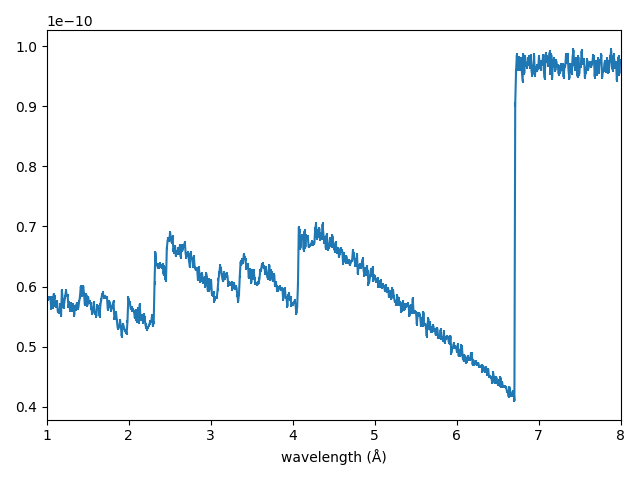

In [7]:
datafile = outdir / 'monitor2.dat'
assert datafile.exists(), "Monitor file not found"
!head -30 {datafile}

x=np.genfromtxt(datafile)
L2, I2, I2_err, N = x.T

fig=plt.figure()
plt.errorbar(L2,I2,I2_err)
plt.xlabel('wavelength (Å)')
plt.xlim(min_lambda, max_lambda)
plt.show()

Plot transmission and compare with the theoretical (uncollided) transmission:

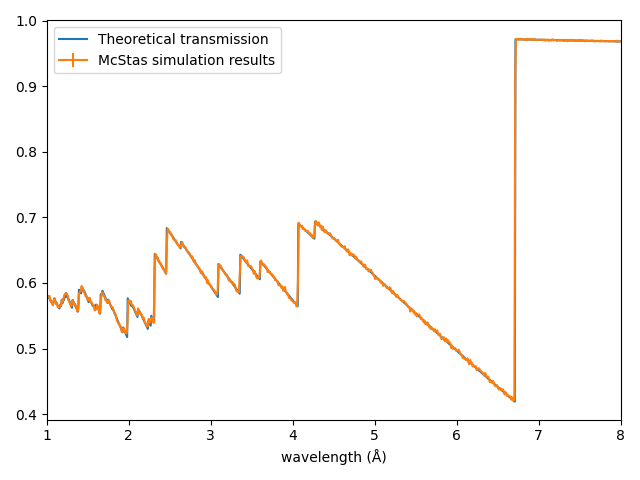

In [8]:
fig=plt.figure()

wl = np.linspace(min_lambda, max_lambda, 1000)
mat1 = NC.load(cfg)
xs1 = mat1.scatter.xsect(wl=wl)+mat1.absorption.xsect(wl=wl)

N1 = mat1.info.getNumberDensity()
plt.plot(wl,np.exp(-N1*xs1*sample_thickness*100), label='Theoretical transmission') # convert sample thickness to cm

plt.errorbar(L2,I2/I,I2_err, label='McStas simulation results')
plt.xlabel('wavelength (Å)')
plt.xlim(min_lambda, max_lambda)
plt.legend()
plt.show()

## Exercise

- Reduce the sample-detector distance to study the effect of in-scattering.
- Modify the material to see temperature effects.

In [9]:
## Your code